## Importing Dependencies

In [1]:
import os
import numpy as np

import cv2
import matplotlib.pylab as plt

import tensorflow as tf

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

## Loading Datasets

In [3]:
train_dir = 'imgdata_v2/split_dataset/train_aug/'
test_dir = 'imgdata_v2/split_dataset/test/'
val_dir = 'imgdata_v2/split_dataset/val/'

In [4]:
train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir, image_size=(256, 256))
val_dataset = tf.keras.utils.image_dataset_from_directory(val_dir, image_size=(256, 256))

Found 7051 files belonging to 2 classes.
Found 415 files belonging to 2 classes.


## Scaling Dataset

In [5]:
train_dataset.as_numpy_iterator().next()[0][0].max()

255.0

In [6]:
train_data = train_dataset.map(lambda x, y: (x/255, y))

In [7]:
train_data.as_numpy_iterator().next()[0][0].max()

1.0

In [8]:
val_data = val_dataset.map(lambda x, y: (x/255, y))

## VGG16 Model

In [10]:
from keras.layers import Dense, Flatten
from keras.models import Model
from keras.applications.inception_v3 import InceptionV3

In [11]:
inception = InceptionV3(input_shape=(256, 256, 3), weights='imagenet', include_top=False)

87910968/87910968 [==============================] - 20s 0us/step


In [13]:
for layer in inception.layers:
    layer.trainaable = False

In [14]:
flatten = Flatten()(inception.output)

prediction = Dense(1, activation='sigmoid')(flatten)

model = Model(inputs=inception.input, outputs=prediction)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 127, 127, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 127, 127, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

In [15]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger
logdir = 'LogDir'

try:
    os.mkdir('saved_models')
    os.mkdir('CSV_logs')
    os.mkdir(logdir)
except Exception as e:
    pass    

tfb_callback = tf.keras.callbacks.TensorBoard(logdir)
early_stop = EarlyStopping(monitor='val_loss', patience=3, verbose=1)
log_csv = CSVLogger('CSV_logs/inception_v3.csv', separator=',', append=False)

callbacks_list = [tfb_callback, early_stop, log_csv]

In [16]:
model_fit = model.fit(train_data, 
                       epochs=5, 
                       shuffle=True, 
                       validation_data=val_data,
                       callbacks=callbacks_list)

Epoch 1/5
221/221 [==============================] - 269s 1s/step - loss: 0.4322 - accuracy: 0.9078 - val_loss: 2097.4744 - val_accuracy: 0.6940
Epoch 2/5
221/221 [==============================] - 240s 1s/step - loss: 0.5011 - accuracy: 0.8769 - val_loss: 2605.1121 - val_accuracy: 0.5157
Epoch 3/5
221/221 [==============================] - 234s 1s/step - loss: 0.2092 - accuracy: 0.9219 - val_loss: 2.5282 - val_accuracy: 0.9277
Epoch 4/5
221/221 [==============================] - 232s 1s/step - loss: 0.2863 - accuracy: 0.9004 - val_loss: 0.1900 - val_accuracy: 0.9205
Epoch 5/5
221/221 [==============================] - 233s 1s/step - loss: 0.1411 - accuracy: 0.9434 - val_loss: 0.1748 - val_accuracy: 0.9253


## Model Performance 

Text(0.5, 0.98, 'InceptionV3 Model Performance Curves')

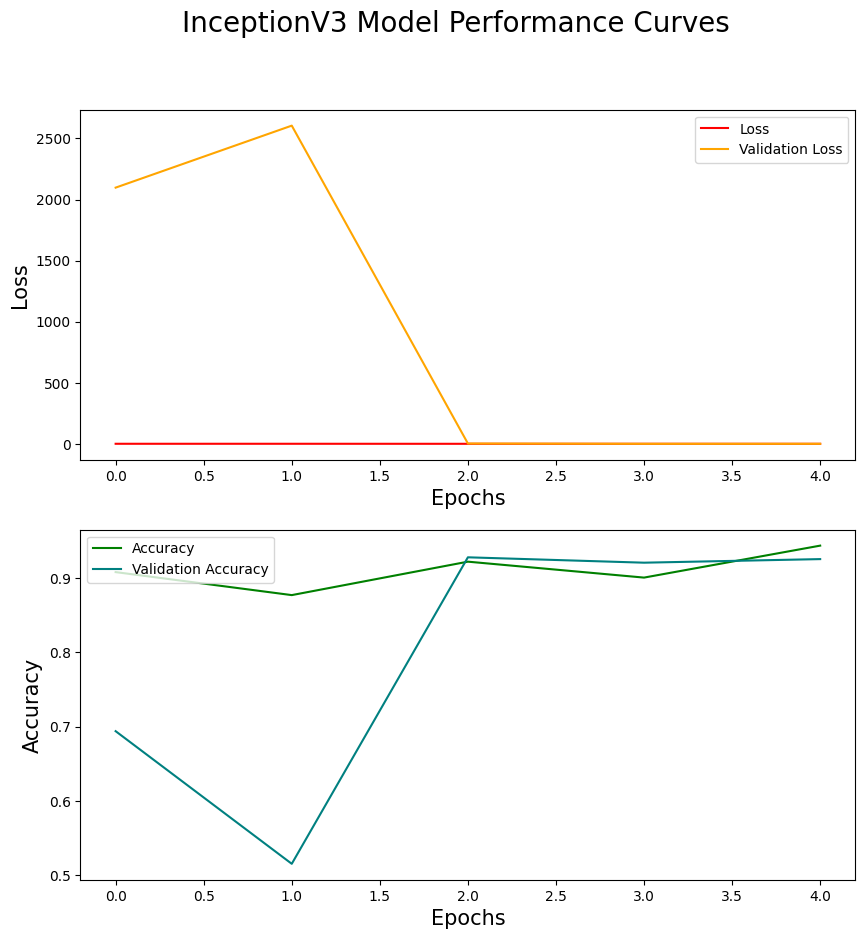

In [17]:
fig, axs = plt.subplots(2, 1, figsize=(10,10))
axs[0].plot(model_fit.history['loss'], 
            color='red', 
            label='Loss')
axs[0].plot(model_fit.history['val_loss'], 
            color='orange', 
            label='Validation Loss')
axs[0].legend(loc='upper right')
axs[0].set_xlabel('Epochs', fontsize=15)
axs[0].set_ylabel('Loss', fontsize=15)


axs[1].plot(model_fit.history['accuracy'], 
             color='green', 
             label='Accuracy')
axs[1].plot(model_fit.history['val_accuracy'], 
             color='teal', 
             label='Validation Accuracy')
axs[1].legend(loc='upper left')
axs[1].set_xlabel('Epochs', fontsize=15)
axs[1].set_ylabel('Accuracy', fontsize=15)

fig.suptitle('InceptionV3 Model Performance Curves', fontsize=20)

## Exporting Model

In [18]:
from keras.models import save_model, load_model

model.save(os.path.join('models_Reboot/','InceptionV3_Re.h5'))

In [19]:
Model = load_model(os.path.join('models_Reboot/','InceptionV3_Re.h5'))

In [20]:
Model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 127, 127, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 127, 127, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

## Evaluating Model

In [25]:
test_dataset = tf.keras.utils.image_dataset_from_directory(test_dir, image_size=(256, 256))

Found 210 files belonging to 2 classes.


In [26]:
test_data = test_dataset.map(lambda x, y : (x/255, y))

In [27]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

pre = Precision()
acc = BinaryAccuracy()
rec = Recall()

In [28]:
for batch in test_data.as_numpy_iterator():
    X, y = batch
    y_pred = Model.predict(X)
    
    acc.update_state(y, y_pred)
    pre.update_state(y, y_pred)
    rec.update_state(y, y_pred)

1/1 [==============================] - 2s 2s/step


In [29]:
accuracy = acc.result().numpy()
precision = pre.result().numpy()
recall = rec.result().numpy()
f1 = 2 * (precision*recall) / (precision+recall)

print('Accuracy\t:', round(accuracy,5))
print('Precision\t:', round(precision,5))
print('Recall\t\t:', round(recall,5))
print('F1\t\t:', round(f1,5))

Accuracy	: 0.96667
Precision	: 0.99029
Recall		: 0.94444
F1		: 0.96682


1/1 [==============================] - 0s 60ms/step


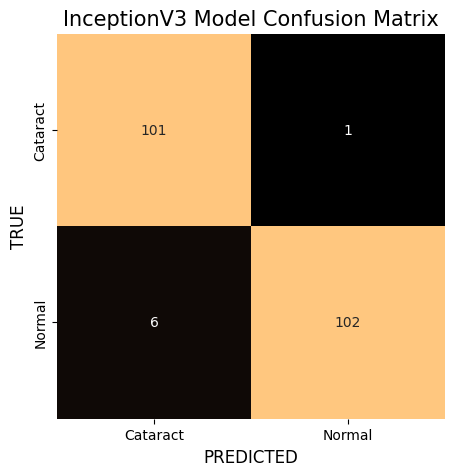

In [32]:
import seaborn as sns

Y=[]
Y_pred=[]
for batch in test_data.as_numpy_iterator():
    X, y = batch
    y_pred = Model.predict(X)
    y_pred = (y_pred > 0.5)
    Y.extend(y)
    Y_pred.extend(y_pred)

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y, Y_pred)

plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='copper', cbar=False,
            xticklabels=['Cataract', 'Normal'], yticklabels=['Cataract', 'Normal'])
plt.xlabel('PREDICTED', fontsize=12)
plt.ylabel('TRUE', fontsize=12)
plt.title('InceptionV3 Model Confusion Matrix', fontsize=15)
plt.show()